In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Nikhil's working path
%cd drive/My\ Drive/'Captstone(297)'/data

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1auWpfpINZvmJbl0I50kYmpS29bbnesqp/Captstone(297)/data


In [2]:
# # Selina's working path
# %cd drive/My\ Drive/2020_Fall/'Captstone(297)'/data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [4]:
train_la = pd.read_pickle("ip_listing_temporal_train_full.pkl")
test_la = pd.read_pickle("ip_listing_temporal_test_full.pkl")

In [5]:
print('train')
display(train_la[train_la.ip=='100.11.168.44'])
print('test')
display(test_la[test_la.ip=='100.11.168.44'])

train


,ip,rexUrl
98,100.11.168.44,22718-figueroa-st-unit-21
98,100.11.168.44,6151-orange-st-apt-118
98,100.11.168.44,6210-s-van-ness-ave
98,100.11.168.44,9735-baden-ave
98,100.11.168.44,13514-chivers-ave
98,100.11.168.44,1410-brett-pl-unit-238
98,100.11.168.44,830-n-oakway-ave
98,100.11.168.44,6209-pacific-ave-unit-101
98,100.11.168.44,814-e-graves-ave


test


,ip,rexUrl
98,100.11.168.44,28710-indies-ln-canyon-country
98,100.11.168.44,15015-lassen-st
98,100.11.168.44,844-e-meadbrook-st


In [6]:
train_la.head()

,ip,rexUrl
11,1.129.109.119,15819-golden-lantern-ln
11,1.129.109.119,3332-genoa-pl
11,1.129.109.119,12401-moorpark-st-unit-201-studio-city
65,1.65.170.128,1270-bayport-cir
65,1.65.170.128,656-w-avenue-j8


In [7]:
! pip install surprise

     |████████████████████████████████| 11.8MB 1.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670938 sha256=021c5060717cba7b384163fd77c56a6dbbe16c50872159134f149a48c577447a
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [8]:
import surprise
from surprise import Reader, Dataset
from surprise import SVD
from surprise import NMF
from surprise import Dataset
from surprise import accuracy


from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

In [9]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
      ratings = pd.DataFrame(user_ratings,columns=['listing','score'])
      ratings.sort_values('score',ascending=False,inplace=True)
      ratings['rank'] = ratings['score'].rank(method='dense',ascending=False)
      top_n[uid] = [tuple(x) for x in ratings[ratings['rank']<=n][['listing','score']].values.tolist()]
      # display(ratings)

      # user_ratings.sort(key=lambda x: x[1], reverse=True)
      # print(user_ratings)
      # top_n[uid] = user_ratings[:n]

    return top_n

def get_recall(top_n_in):
  recalls = []
  for test_ip in set(testset.ip):
    recommended = [i[0] for i in top_n_in[test_ip]]
    true = testset[testset.ip==test_ip].groupby('ip')['rexUrl'].apply(list).values[0]

    intersection = len(list(set(recommended) & set(true)))

    recalls.append(intersection/len(true))
    ans = np.mean(recalls)
  return ans

### Scores (depracated)

In [ ]:
# def calculate_score(row):
#   curr_score = 0
#   for i in range(4):
#     curr_weight = np.clip(1/level_weights[i],0,6)
#     curr_score += row[f'level{i}_ct']*curr_weight
#   return min(6, curr_score)

# # Based on Selina score rule
# group_df_pre['score'] = group_df_pre.apply(lambda x: calculate_score(x), axis=1)

# ## input for CF model
# df_grp = group_df_pre.reset_index()[['ip', 'rexUrl','score']]
# print("Input for CF model: ", df_grp.shape)
# df_grp.head()

Input for CF model:  (2047, 3)


,ip,rexUrl,score
0,100.12.89.134,945-acacia-ln,0.030304
1,100.14.25.252,15820-galaxy-pl,0.040405
2,100.14.25.252,22301-cass-ave,0.030304
3,100.33.124.105,244-s-avenue-24,0.030304
4,100.33.51.236,44629-17th-st-e,0.030304


## Modeling

## Testing Reconstructions on ALL DATA

In [ ]:
# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

df_grp = ip_url.copy()

cf_df = pd.DataFrame({'itemID': list(df_grp.rexUrl),
                   'userID': list(df_grp.ip),
                   'rating': list(df_grp.score)})
reader = Reader(rating_scale=(0, 1))

cf_df = Dataset.load_from_df(cf_df[['userID', 'itemID', 'rating']], reader)

### Gridsearch NMF

In [ ]:
param_grid = {'n_factors': [5, 10,15,20], 
              'n_epochs': [50,60,70],
              'reg_pu': [0.04, 0.05, 0.06, 0.07, 0.08],
              'reg_qi': [0.04, 0.05, 0.06, 0.07, 0.08]}


gs = surprise.model_selection.GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

gs.fit(cf_df)

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.sort_values('rank_test_rmse').head(3)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi
52,0.055088,0.050798,0.056323,0.054069,0.002368,1,0.300227,0.015696,0.006074,0.000031,"{'n_factors': 5, 'n_epochs': 70, 'reg_pu': 0.0...",5,70,0.04,0.06
275,0.053587,0.057000,0.052434,0.054341,0.001939,2,0.534944,0.007760,0.006184,0.000293,"{'n_factors': 20, 'n_epochs': 70, 'reg_pu': 0....",20,70,0.04,0.04
202,0.056675,0.055999,0.050667,0.054447,0.002687,3,0.449148,0.005120,0.006128,0.000040,"{'n_factors': 15, 'n_epochs': 70, 'reg_pu': 0....",15,70,0.04,0.06


### GridSearch SVD

In [ ]:
param_grid2 = {'n_factors': [80, 90,100,110,120], 
               'n_epochs': [5,10,20,30,40],
              'lr_all': [0.004,0.005,0.006,0.007],
              'reg_all': [0.01, 0.02, 0.03, 0.04, 0.05]}


gs2 = surprise.model_selection.GridSearchCV(SVD, param_grid2, measures=['rmse'], cv=3, n_jobs=-1)

gs2.fit(cf_df)

In [ ]:
results_df2 = pd.DataFrame.from_dict(gs2.cv_results)
results_df2.sort_values('rank_test_rmse').head(3)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
99,0.020369,0.018017,0.023064,0.020483,0.002062,1,0.287593,0.029161,0.006516,0.000125,"{'n_factors': 80, 'n_epochs': 40, 'lr_all': 0....",80,40,0.007,0.05
94,0.022113,0.020292,0.022042,0.021483,0.000842,2,0.297656,0.034026,0.008592,0.003378,"{'n_factors': 80, 'n_epochs': 40, 'lr_all': 0....",80,40,0.006,0.05
199,0.022443,0.022445,0.021654,0.022181,0.000372,3,0.308903,0.015871,0.006303,0.000187,"{'n_factors': 90, 'n_epochs': 40, 'lr_all': 0....",90,40,0.007,0.05


### Testing best Model - SVD with params found with GridSearch above

In [ ]:
# define a cross-validation iterator
kf = KFold(n_splits=5)

algo_la = SVD(n_factors=80, n_epochs=40,lr_all=0.007,reg_all=0.05)

for trainset, testset in kf.split(cf_df):

    # train and test algorithm.
    algo_la.fit(trainset)
    predictions = algo_la.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.0176
RMSE: 0.0223
RMSE: 0.0171
RMSE: 0.0221
RMSE: 0.0229


## Testing finding seen listings on temporally split data

In [10]:
trainset = train_la.copy()
trainset['score'] = 1

testset = test_la.copy()
# testset['score'] = 1

In [11]:
reader = Reader(rating_scale=(0, 1))

collab_filter_train = pd.DataFrame({'itemID': list(trainset.rexUrl),
                                    'userID': list(trainset.ip),
                                    'rating': list(trainset.score)})

collab_filter_data = Dataset.load_from_df(collab_filter_train[['userID', 'itemID', 'rating']], reader)
collab_filter_temporal_train = collab_filter_data.build_full_trainset()

In [ ]:
param_grid = {'n_factors': [80, 90,100,110,120], 
               'n_epochs': [5,10,20,30,40],
              'lr_all': [0.004,0.005,0.006,0.007],
              'reg_all': [0.01, 0.02, 0.03, 0.04, 0.05]}


gsearch = surprise.model_selection.GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1,joblib_verbose=1)

gsearch.fit(collab_filter_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 60.6min finished


In [ ]:
# results_df.to_pickle('long_gridsearch_results.pkl')

In [ ]:
results_df = pd.DataFrame.from_dict(gsearch.cv_results)
results_df.sort_values('rank_test_rmse').head(3)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
99,0.014328,0.014461,0.013907,0.014232,0.000236,1,6.664944,0.171024,0.274532,0.082422,"{'n_factors': 80, 'n_epochs': 40, 'lr_all': 0....",80,40,0.007,0.05
199,0.014374,0.015242,0.015232,0.014949,0.000407,2,7.271407,0.190990,0.264765,0.095069,"{'n_factors': 90, 'n_epochs': 40, 'lr_all': 0....",90,40,0.007,0.05
299,0.015626,0.015384,0.015863,0.015625,0.000195,3,7.831335,0.069127,0.245230,0.099990,"{'n_factors': 100, 'n_epochs': 40, 'lr_all': 0...",100,40,0.007,0.05


In [12]:
# algo_best = SVD(n_factors=110, n_epochs=10,lr_all=0.005,reg_all=0.02,random_state=297)
algo_best = SVD(n_factors=80, n_epochs=40,lr_all=0.007,reg_all=0.05,random_state=297)

algo_best.fit(collab_filter_temporal_train)

#The ratings are all the ratings that are not in the trainset, i.e. all the ratings 𝑟𝑢𝑖 where the user 𝑢 is known, the item 𝑖 is known, but the rating 𝑟𝑢𝑖 is not in the trainset. 
predictions = algo_best.test(collab_filter_temporal_train.build_anti_testset(fill=0))

In [13]:
def precision_recall_at_k(k_in):
  top_k = get_top_n(predictions, n=k_in)

  recall_results = {}
  precision_results = {}

  for ip_curr in trainset.ip.unique():
    top_k_for_ip_curr = pd.DataFrame(top_k[ip_curr],columns=['rexUrl','score'])
    
    # Recommended items
    recommended_at_k = top_k_for_ip_curr[top_k_for_ip_curr.score>0.5].rexUrl.values

    #Possible Relevant items
    #Get true temporally held out listings for that user
    true_for_ip_curr = testset[testset.ip==ip_curr].rexUrl.values

    # Recommendations that are relevant
    # find overlap
    correctly_found_ip_curr = list(set(recommended_at_k) & set(true_for_ip_curr))


    recall_results[ip_curr] = len(correctly_found_ip_curr)/len(true_for_ip_curr)
    precision_results[ip_curr] = len(correctly_found_ip_curr)/len(recommended_at_k)

  return recall_results, precision_results

In [14]:
recall_results_10, precision_results_10 = precision_recall_at_k(10)

In [15]:
#NEW
print('precision @ 10', np.mean(list(precision_results_10.values())))
print('recall @ 10', np.mean(list(recall_results_10.values())))

precision @ 10 0.004567334481309653
recall @ 10 0.5502090247736763


In [ ]:
print('precision @ 10', np.mean(list(precision_results_10.values())))
print('recall @ 10', np.mean(list(recall_results_10.values())))

precision @ 10 0.004567334481309653
recall @ 10 0.5502090247736763


In [ ]:
recall_results_20, precision_results_20 = precision_recall_at_k(20)

In [ ]:
print('precision @ 20', np.mean(list(precision_results_20.values())))
print('recall @ 20', np.mean(list(recall_results_20.values())))

precision @ 20 0.0048566188533586295
recall @ 20 0.600243206774205


In [ ]:
recall_results_30, precision_results_30 = precision_recall_at_k(30)

In [ ]:
print('precision @ 30', np.mean(list(precision_results_30.values())))
print('recall @ 30', np.mean(list(recall_results_30.values())))

precision @ 30 0.005153481011048522
recall @ 30 0.6555793628206514


In [ ]:
recall_results_all, precision_results_all = precision_recall_at_k(500)

In [ ]:
print('precision all', np.mean(list(precision_results_all.values())))
print('recall all', np.mean(list(recall_results_all.values())))

precision all 0.004582188021537515
recall all 0.9991031449349641


## Predictions (unseen test) distribution

In [ ]:
predictions_est = [x[3] for x in predictions]

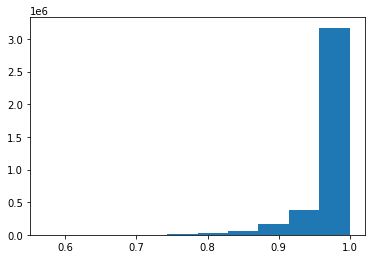

In [ ]:
plt.hist(predictions_est)
plt.show()

##Case

In [16]:
cols = ['rex_url','sqft','price','bedrooms','total_rooms','full_baths','is_apt']

In [17]:
iptest = '104.173.187.33'

In [19]:
top_k = get_top_n(predictions, n=10)
top_k_for_ip_curr = pd.DataFrame(top_k[iptest],columns=['rexUrl','score'])

# Recommended items
recommended_at_k = top_k_for_ip_curr[top_k_for_ip_curr.score>0.5].rexUrl.values

#Possible Relevant items
#Get true temporally held out listings for that user
true_for_ip_curr = testset[testset.ip==iptest].rexUrl.values

In [25]:
listing_data = pd.read_pickle('LOG_siamese_data_11_12.pkl')

In [40]:
toprecs_case = pd.DataFrame({'rexUrl':blah})
toprecs_case = toprecs_case.merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
toprecs_case['sqft'] = np.exp(toprecs_case['log_sqft']).map('{:,.0f}'.format)
toprecs_case['price'] = np.exp(toprecs_case['log_price']).map('{:,.0f}'.format)
toprecs_case['total_rooms'] = np.exp(toprecs_case['log_total_rooms'])

In [41]:
toprecs_case[cols]

,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,1435-w-146th-st-apt-202,"1,028","370,000",2.0,4.0,2.0,1.0
1,10419-bellder-dr,"7,370","2,600,000",6.0,6.0,7.0,0.0
2,5850-ernest-ave,"1,902","1,175,000",4.0,5.0,4.0,0.0
3,11473-killion-st,"3,358","1,200,000",8.0,6.0,4.0,0.0
4,21314-nandina-ln-unit-202,943,"326,531",2.0,5.0,2.0,1.0
5,746-n-eucalyptus-ave-apt-21,"1,045","367,000",2.0,4.0,2.0,1.0
6,24718-via-kostas,"2,425","879,000",3.0,8.0,3.0,0.0
7,15622-nahin-ln,"3,619","694,950",5.0,13.0,4.0,0.0
8,11218-camarillo-st-apt-104,"1,860","619,000",3.0,6.0,3.0,1.0
9,3591-soledad-canyon-rd,"1,680","575,000",3.0,7.0,2.0,0.0


In [29]:
true_for_ip_curr

array(['22718-figueroa-st-unit-21', '3591-soledad-canyon-rd',
       '6345-colbath-ave'], dtype=object)

In [32]:
'6345-colbath-ave' in recommended_at_k

False

In [33]:
np.argwhere(np.array(recommended_at_k)=='3591-soledad-canyon-rd')

array([[195]])

In [38]:
blah = list(recommended_at_k[:9])
blah.append(recommended_at_k[195])